###RFM analysis

**RFM analysis** is a marketing framework that seeks to understand and analyze customer behavior based on three factors/metrics:

1. **Recency:**
Freshness of customer activity, be it purchases or visits. E.g. The time elapsed since a customer bought or last engaged with a product.
2. **Frequency:**
Frequency of customer transactions or visits. E.g. Total number of transactions or average time between transactions/engaged visits.
3. **Monetory:**
Purchasing power of customer.E.g. The total average value of customer transaction.


RFM metrics illustrate the following facts:
* The more recent the purchase, the more responsive the customer is to promotions.
* The more frequently the buys, the more engaged and satisfied they are.
* Monetary value differentiates heavy spenders from low-value purchasers.


Further RFM analysis helps to answer the following questions:
* Who are the best customers?
* Which of the customers could contribute to churn rate or the rate at which a customer stops doing business with an organization?
* Who has the potential to become valuable customers?
* Which of the customers can be retained?
* Which of the customers are most likely to respond to engagement?

**The RFM Analysis will help the businesses to segment their customer base into different homogenous groups so that they can engage with each group with different targeted marketing strategies/campaigns.**



Working of RFM analysis:

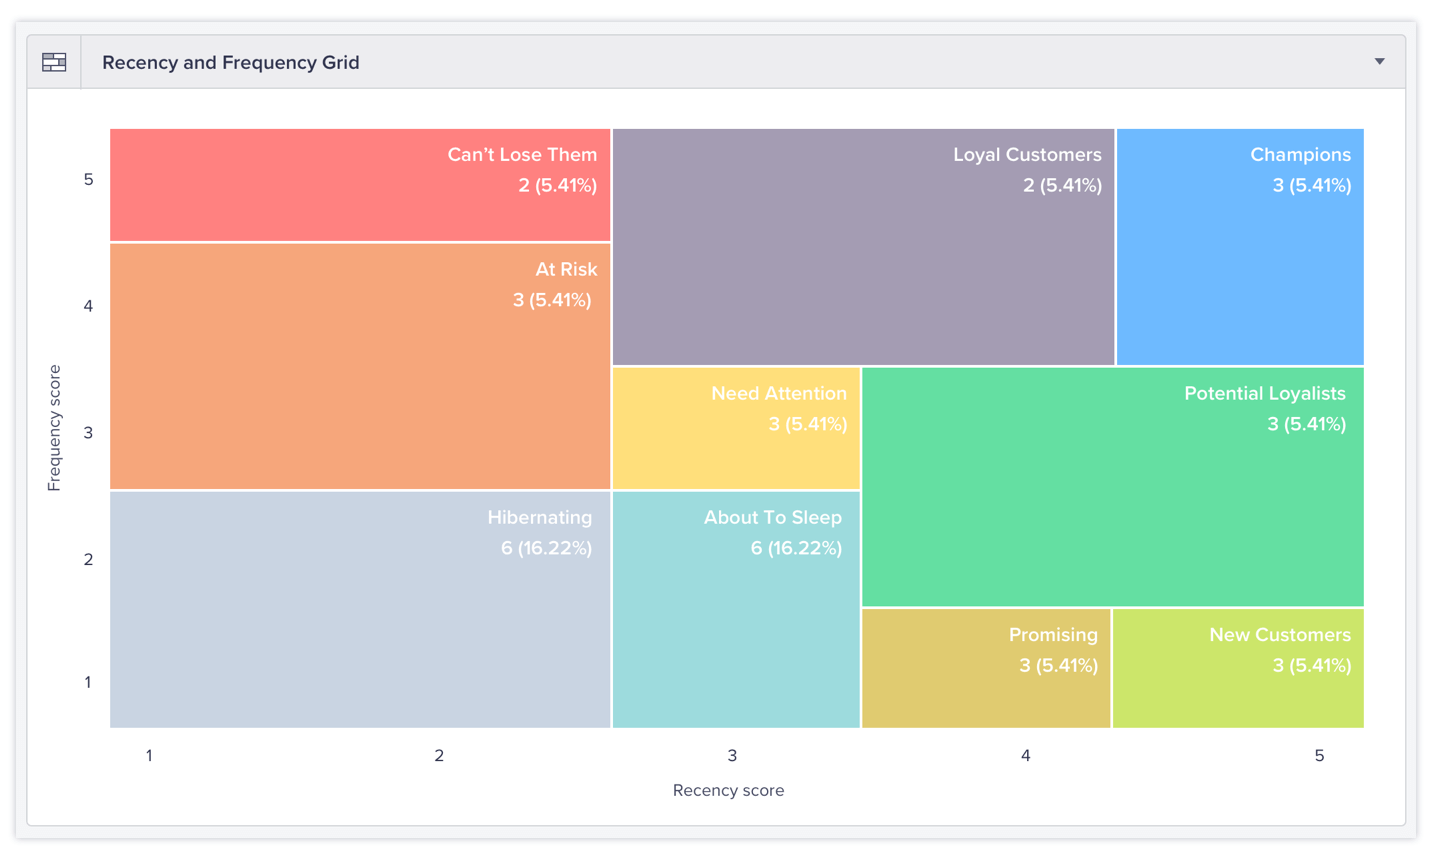

**Finding Recency, Monetary and Frequency**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 15

In [ ]:
def load_csv(path):

  csv_path = Path(path)
  if csv_path.is_file():
    data = pd.read_csv(csv_path, encoding= 'unicode_escape')
  else:
    raise ValueError('Error while reading the csv file.')
  return data

preprocessed_data = load_csv('/content/drive/MyDrive/Leapfrog_internship/Major Project/commerce_data.csv')
preprocessed_data.head()

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,spend_amount,customer_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


The data is available from the 1st of December of 2010 and 9th of December of 2011, analysis for todays date will not give the relevant information, so the analysis has been done for the date after exactly one month i.e. 9th of Jan of 2012.

In [ ]:
preprocessed_data.invoice_date = pd.to_datetime(preprocessed_data.invoice_date)
preprocessed_data.customer_id = preprocessed_data.customer_id.astype('int64')

As clusters may vary by geography, RFM analysis is done for a total of 5 different countries separatively in which the sales are the most. UK is the homecountry where the sales is maximum, we start from here and then do for Germany, France, Ireland and Spain.

In [ ]:
preprocessed_data = preprocessed_data[preprocessed_data['country'] == 'United Kingdom']
preprocessed_data.shape

(348643, 9)

The invoice_date represents the days between the last purchase and today's date of each customer (recency).

The spend_amount represents the total amount of money spend by each customer (monetary).



In [ ]:
  
today = dt.datetime(2012, 1, 9)
data_monetary_recency = preprocessed_data.groupby('customer_id').agg({'spend_amount': lambda x: x.sum(),
                                        'invoice_date': lambda x: (today - x.max()).days})
data_temp = preprocessed_data.groupby(['customer_id', 'invoice_num']).agg({'spend_amount': lambda x: x.sum()})
data_frequency = data_temp.groupby('customer_id').agg({'spend_amount': lambda x: len(x)})
data_rfm = pd.merge(data_monetary_recency, data_frequency, on='customer_id')
data_rfm.rename(columns={'invoice_date': 'recency', 'spend_amount_y': 'frequency', 'spend_amount_x': 'monetary'}, inplace=True)
data_rfm.head()


,monetary,recency,frequency
customer_id,,,
12346,77183.60,355,1.0
12747,4196.01,32,11.0
12748,33046.79,30,209.0
12749,4090.88,33,5.0
12820,942.34,33,4.0


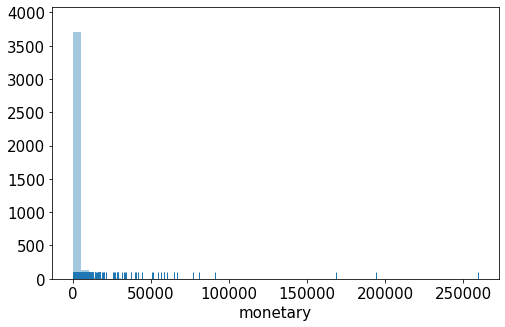

In [ ]:
plt.figure(figsize=(8, 5))
sns.distplot(data_rfm.monetary, kde=False, rug=True)

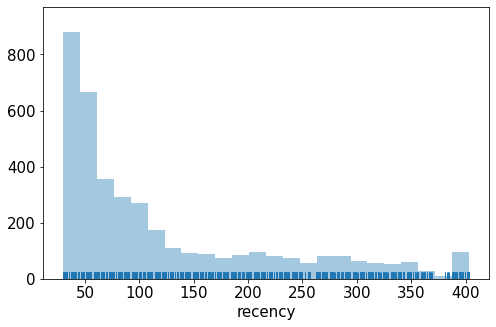

In [ ]:
plt.figure(figsize=(8, 5))
sns.distplot(data_rfm.recency, kde=False, rug=True)

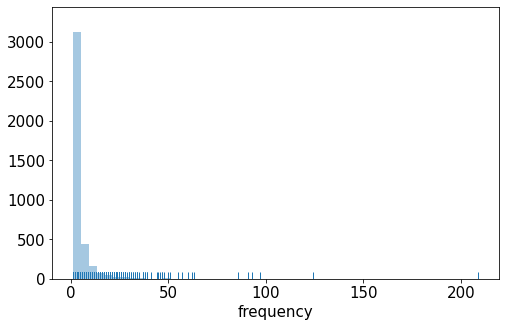

In [ ]:
plt.figure(figsize=(8, 5))
sns.distplot(data_rfm.frequency, kde=False, rug=True)

In [ ]:

quantiles = data_rfm[['recency', 'frequency', 'monetary']].quantile(q=[0.20,0.40,0.60,0.80])

def r_score(r, values):
    if r < quantiles[values][0.20]:
        return 5 
    elif r < quantiles[values][0.40]:
        return 4
    elif r < quantiles[values][0.60]:
        return 3
    elif r < quantiles[values][0.80]:
        return 2
    else: 
        return 1

def fm_score(r, values):
    if r > quantiles[values][0.80]:
        return 5 
    elif r > quantiles[values][0.60]:
        return 4
    elif r > quantiles[values][0.40]:
        return 3
    elif r > quantiles[values][0.20]:
        return 2
    else: 
        return 1

rfm_df_score = data_rfm.copy()
rfm_df_score['r_score'] = rfm_df_score.recency.apply(lambda x: r_score(x, 'recency'))
rfm_df_score['f_score'] = rfm_df_score.frequency.apply(lambda x: fm_score(x, 'frequency'))
rfm_df_score['m_score'] = rfm_df_score.monetary.apply(lambda x: fm_score(x, 'monetary'))
rfm_df_score['rfm_score'] = rfm_df_score['r_score'].map(str)+rfm_df_score['f_score'].map(str) + rfm_df_score['m_score'].map(str)
rfm_df_score['rf_score'] = rfm_df_score['r_score'].map(str)+rfm_df_score['f_score'].map(str)
rfm_df_score.head(3)

,monetary,recency,frequency,r_score,f_score,m_score,rfm_score,rf_score
customer_id,,,,,,,,
12346,77183.60,355,1.0,1,1,5,115,11
12747,4196.01,32,11.0,5,5,5,555,55
12748,33046.79,30,209.0,5,5,5,555,55


**The top 5 big spenders from United Kingdom.**

In [ ]:
rfm_df_score[rfm_df_score['rfm_score'] == '555'].sort_values('monetary', ascending=False).head()

,monetary,recency,frequency,r_score,f_score,m_score,rfm_score,rf_score
customer_id,,,,,,,,
18102,259657.30,30,60.0,5,5,5,555,55
17450,194390.79,38,46.0,5,5,5,555,55
17511,90992.78,32,31.0,5,5,5,555,55
16684,66653.56,34,28.0,5,5,5,555,55
13694,65039.62,33,50.0,5,5,5,555,55


**The top 5 customers who have the possiblity to stop shopping.**

In [ ]:
rfm_df_score[rfm_df_score['r_score'] <= 2 ].sort_values('monetary', ascending=True).head()

,monetary,recency,frequency,r_score,f_score,m_score,rfm_score,rf_score
customer_id,,,,,,,,
16738,3.75,327,1.0,1,1,1,111,11
17956,12.75,279,1.0,1,1,1,111,11
16878,13.30,114,1.0,2,1,1,211,21
17763,15.00,293,1.0,1,1,1,111,11
13307,15.00,150,1.0,2,1,1,211,21


**The lost customers.**

In [ ]:
rfm_df_score[rfm_df_score['rfm_score'] == '111'].sort_values('recency',ascending=False).head()

,monetary,recency,frequency,r_score,f_score,m_score,rfm_score,rf_score
customer_id,,,,,,,,
14237,161.00,403,1.0,1,1,1,111,11
18011,102.79,403,1.0,1,1,1,111,11
16583,233.45,403,1.0,1,1,1,111,11
17908,232.03,403,1.0,1,1,1,111,11
17643,101.55,403,1.0,1,1,1,111,11


In [ ]:
seg_map = {
    r'[4-5][4-5]': 'Champions',
    r'[3-4][4-5]': 'Loyal Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'[3-4][0-1]': 'Promising',
    r'[1-2]5': "Can't lose",
    r'[1-3][1-4]': 'At risk',
    r'[4-5][0-1]': 'New Customers',
}
rfm_df_score['segments'] = rfm_df_score['rf_score'].replace(seg_map, regex=True)
rfm_df_score.head()

,monetary,recency,frequency,r_score,f_score,m_score,rfm_score,rf_score,segments
customer_id,,,,,,,,,
12346,77183.60,355,1.0,1,1,5,115,11,At risk
12747,4196.01,32,11.0,5,5,5,555,55,Champions
12748,33046.79,30,209.0,5,5,5,555,55,Champions
12749,4090.88,33,5.0,5,4,5,545,54,Champions
12820,942.34,33,4.0,5,4,4,544,54,Champions


Text(0.5, 1.0, 'RFM segments')

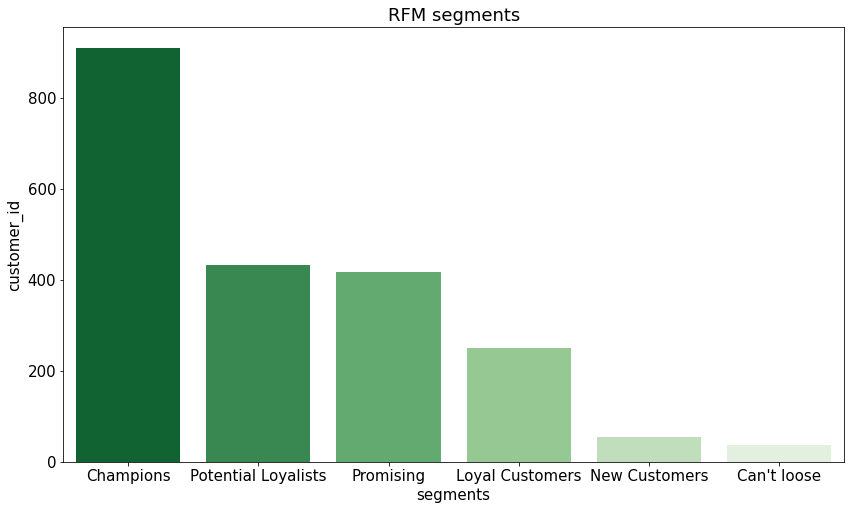

In [ ]:

rfm_df_score.reset_index(inplace=True)
segment_vis = rfm_df_score.groupby('segments')['customer_id'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14, 8))
segment_vis.drop([0], inplace = True)
sns.barplot(data=segment_vis, x='segments', y='customer_id', palette='Greens_r')
plt.title("RFM segments",fontsize=18)


In [ ]:
!pip install squarify

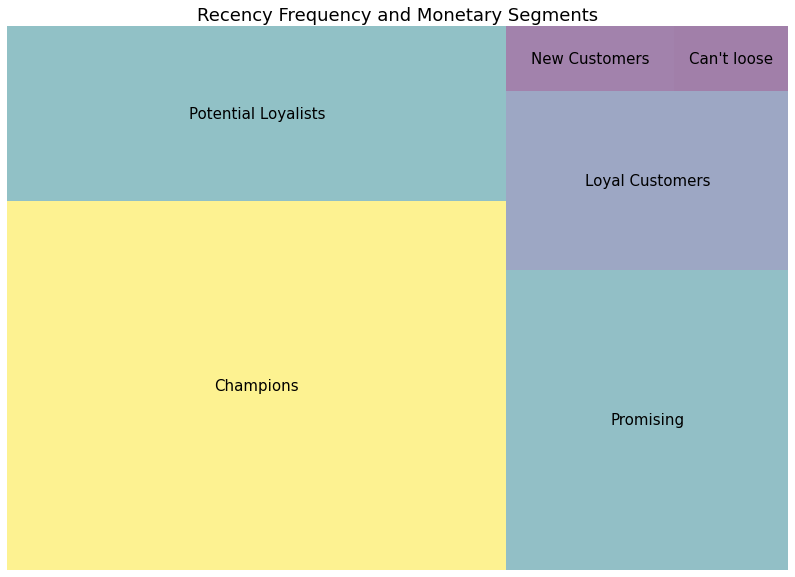

In [ ]:
import squarify
import matplotlib

cmap = matplotlib.cm.viridis
mini = min(segment_vis['customer_id'])
maxi = max(segment_vis['customer_id'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in segment_vis['customer_id']]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
squarify.plot(sizes=segment_vis['customer_id'], label=segment_vis.segments, alpha=0.5, color=colors)
plt.title("Recency Frequency and Monetary Segments",fontsize=18)
plt.axis('off')
plt.show()

In [ ]:
rfm_segment_agg = rfm_df_score.groupby('segments').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(1)
print(rfm_segment_agg)

                    recency frequency monetary      
                       mean      mean     mean count
segments                                            
At risk               199.3       1.9    699.9  1820
Can't loose           160.1      10.1   3356.3    37
Champions              41.7      10.7   5002.8   910
Loyal Customers        77.6       6.3   2618.9   249
New Customers          36.5       1.0    343.8    54
Potential Loyalists    45.6       2.4   1194.7   432
Promising              70.9       1.0    330.4   418


**Analyzing all the customer segments.**

In [ ]:
champions = rfm_df_score[rfm_df_score['segments'] == 'Champions']
loyal_customers = rfm_df_score[rfm_df_score['segments'] == 'Loyal Customers']
potential_loyalists = rfm_df_score[rfm_df_score['segments'] == 'Potential Loyalists']
promising = rfm_df_score[rfm_df_score['segments'] == 'Promising']
cant_loose = rfm_df_score[rfm_df_score['segments'] == "Can't lose"]
at_risk = rfm_df_score[rfm_df_score['segments'] == 'At risk']
new_customer = rfm_df_score[rfm_df_score['segments'] == 'New Customers']


In [ ]:
segment = champions[['recency','frequency','monetary']].agg(['mean', 'count'])
segment['recency'].loc['count']
segment

,recency,frequency,monetary
mean,41.681319,10.667033,5002.818835
count,910.000000,910.000000,910.000000


This 910 customers are the best customers of the company, they are shopping alomst 10 times in the span of 41 days and they are as well spending almost 5002 sterlings everytime they shop.
* These customers should be treated with priority and special call can be made to these people. Gift vouchers can also be defined.

In [ ]:
loyal_customers[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,77.594378,6.349398,2618.875265
count,249.000000,249.000000,249.000000


These 249 customers are the loyal customers of the company, they are shopping almost 6 times in 77 days. 

* Loyalty cards can be created in which these customers can gain points each time of purchasing and these points could transfer into a discount.

In [ ]:
potential_loyalists[['recency','frequency','monetary']].agg(['mean', 'count'])


,recency,frequency,monetary
mean,45.55787,2.425926,1194.749769
count,432.00000,432.000000,432.000000


These 432 customers are the potential loyal customers of the company, they are shopping 2 times in 45 days and are also spending an adequate amount of money.
* These customers should be .........

In [ ]:
promising[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,70.916268,1.0,330.396268
count,418.000000,418.0,418.000000


In [ ]:
cant_loose[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,160.108108,10.135135,3356.272973
count,37.000000,37.000000,37.000000


In [ ]:
at_risk[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,199.317033,1.902198,699.930375
count,1820.000000,1820.000000,1820.000000


In [ ]:
new_customer[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,36.537037,1.0,343.830926
count,54.000000,54.0,54.000000


In [ ]:
preprocessed_data.reset_index(drop=True)
champions.reset_index(drop=True)
champions_total_data = preprocessed_data.loc[preprocessed_data.customer_id.isin(champions.customer_id)]
champions_total_data.groupby(['customer_id']).first().reset_index().sort_values

,customer_id,invoice_num,invoice_date,stock_code,description,quantity,unit_price,spend_amount,country
0,12747,537215,2010-12-05 15:38:00,85124C,green juicy fruit photo frame,12,2.55,30.60,United Kingdom
1,12748,536521,2010-12-01 12:48:00,22854,cream sweetheart egg holder,1,4.95,4.95,United Kingdom
2,12749,552694,2011-05-10 15:25:00,22768,family photo frame cornice,2,9.95,19.90,United Kingdom
3,12820,541283,2011-01-17 12:34:00,21977,pack of 60 pink paisley cake cases,24,0.55,13.20,United Kingdom
4,12826,538107,2010-12-09 15:21:00,22086,paper chain kit 50's christmas,6,2.95,17.70,United Kingdom
...,...,...,...,...,...,...,...,...,...
905,18237,561617,2011-07-28 13:05:00,21668,red stripe ceramic drawer knob,12,1.25,15.00,United Kingdom
906,18241,552045,2011-05-06 09:22:00,85066,cream sweetheart mini chest,2,12.75,25.50,United Kingdom
907,18245,539477,2010-12-19 14:58:00,21992,vintage paisley stationery set,6,2.95,17.70,United Kingdom
908,18272,549185,2011-04-07 09:35:00,20754,retrospot red washing up gloves,6,2.10,12.60,United Kingdom


In [ ]:
def get_customer_id_and_monetary(dataframe):
  return dataframe[['customer_id', 'monetary']].sort_values(by=['monetary'], ascending = False)

get_customer_id_and_monetary(champions)

,customer_id,monetary
3783,18102,259657.30
3314,17450,194390.79
3356,17511,90992.78
2766,16684,66653.56
620,13694,65039.62
...,...,...
2754,16668,306.72
1578,15060,294.25
330,13277,258.40
185,13079,220.10
